# Question A4

In this section, we will understand the utility of such a neural network in real world scenarios.

#### Please use the real record data named ‘record.wav’  as a test sample. Preprocess the data using the provided preprocessing script (data_preprocess.ipynb) and prepare the dataset.
Do a model prediction on the sample test dataset and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons.
Find the most important features on the model prediction for the test sample using SHAP. Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5,
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195)



1. Firstly, we import relevant libraries.

In [6]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
set_seed()

To reduce repeated code, place your
network (MLP defined in QA1)
torch datasets (CustomDataset defined in QA1)
loss function (loss_fn defined in QA1)
in a separate file called common_utils.py

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.


In [7]:
from common_utils import preprocess, CustomDataset, split_dataset, preprocess_dataset, EarlyStopper

# Binary Cross Entropy Loss for binary classification
loss_fn = nn.BCELoss()

# Neural Network with 2 hidden layer as found in Part A_3 to be the optimal hyperparameter
class MLP(nn.Module):
    
    def __init__(self, no_features, no_hidden=128, no_labels=1):
        super(MLP, self).__init__()
        
        # Define the MLP stack using nn.Sequential
        self.mlp_stack = nn.Sequential(
            # First hidden layer
            nn.Linear(no_features, no_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # Apply dropout to the first hidden layer

            # Second hidden layer
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # Apply dropout to the second hidden layer

            # Output layer
            nn.Linear(no_hidden, no_labels),
            nn.Sigmoid()  # Sigmoid activation for the output layer
        )

    def forward(self, x):
        # Pass the input through the network stack
        return self.mlp_stack(x)

2. Install and import shap

In [8]:
!pip install shap

In [9]:
import shap

3. Read the csv data preprocessed from 'record.wav', using variable name 'df', and fill the size of 'df' in 'size_row' and 'size_column'.

In [10]:
df = pd.read_csv('new_record.csv')
size_row, size_column = df.shape

print("size_row = " + str(size_row))
print("size_column = " + str(size_column))

size_row = 1
size_column = 78


In [11]:
# Read the dataset
simplified = pd.read_csv('simplified.csv')

# Create the label from the filename since filename contains the label
simplified['label'] = simplified['filename'].str.split('_').str[-2]

# From the dataset given, we will drop filename and label since filename doesn't provide any detail and label is the prediction task
col_drop = ["filename", "label"]

# Preprocess the dataset (split and scale)
X_train_scaled, y_train, X_test_scaled, y_test = preprocess(simplified, col_drop= col_drop)

In [12]:
print("Shape of X_train_scaled = " + str(X_train_scaled.shape))
print("Shape of X_test_scaled = " + str(X_test_scaled.shape))

Shape of X_train_scaled = (9645, 77)
Shape of X_test_scaled = (2412, 77)


 4.  Preprocess to obtain the test data, save the test data as numpy array.

In [13]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Assuming you have already scaled the training data and want to preprocess the test data
def preprocess(X_train, df):
    """ Preprocess your dataset to obtain your test dataset and ensure it matches the shape of X_train_scaled """
    
    # Drop the 'filename' column as it's not a feature
    X_test = df.drop('filename', axis=1)

    # Handle any potential brackets in the 'tempo' field if they are still present
    if 'tempo' in X_test.columns:
        X_test['tempo'] = X_test['tempo'].apply(lambda x: float(x.strip('[]')) if isinstance(x, str) else x)

    # Load the scaler fitted on the training set
    scaler = StandardScaler()

    # Fit the scaler on X_train (you should have done this when scaling the training data)
    X_train_scaled = scaler.fit_transform(X_train)

    # Scale the test set using the same scaler (do not fit the scaler again, just transform)
    X_test_scaled = scaler.transform(X_test)

    return X_test_scaled

col_drop = ["filename", "label"]  # Drop 'filename' and 'label' columns to get only features
X_train = simplified.drop(columns=col_drop)

# Assuming df contains the test data from 'new_record.csv'
x_test_instance = preprocess(X_train, df)  # Preprocess the test data

# Print the shape to verify it's the same as the training data (1 row, 77 features)
print(x_test_instance.shape)


(1, 77)


5. Do a model prediction on the sample test dataset and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. Note: Please define the variable of your final predicted label as 'pred_label'.

In [14]:
# Initialize the DataLoaders
def intialise_dataloader(X_train_scaled_fold, y_train_fold, X_val_scaled_fold, y_val__fold, batch_size):
    """
    Args:
        X_train_scaled_fold (ndarray): Scaled input features for training for a fold.
        y_train_fold (ndarray): Training labels for a fold.
        X_val_scaled_fold (ndarray): Scaled input features for testing for a fold.
        y_val__fold (ndarray): Test labels for a fold.
        batch_size (int): Batch size for loading the data.

    Returns:
        train_dataloader (DataLoader): Dataloader for the training set.
        validation_dataloader (DataLoader): Dataloader for the validation set.
    """
    # Create instances of the CustomDataset for training and testing
    train_dataset = CustomDataset(X_train_scaled_fold, y_train_fold)
    val_dataset = CustomDataset(X_val_scaled_fold, y_val__fold)

    # Create DataLoaders for training and testing
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, validation_dataloader


def training_loop(dataloader, model, loss_fn, optimizer):
    train_loss, correct_predictions = 0, 0
    total_samples = 0

    for x, y in dataloader:
        pred = model(x)

        # Reshape the target labels to match the shape of the predictions
        y = y.unsqueeze(1).float()

        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        predicted_labels = (pred > 0.5).float()  # Convert probabilities to binary predictions
        correct_predictions += (predicted_labels == y).float().sum().item()
        total_samples += y.size(0)

    train_loss /= len(dataloader)  # Average loss over batches
    accuracy = correct_predictions / total_samples

    return train_loss, accuracy


def validation_loop(dataloader, model, loss_fn):
    val_loss, correct_predictions = 0, 0
    total_samples = 0

    with torch.no_grad():
        for x, y in dataloader:
            pred = model(x)

            # Reshape the target labels to match the shape of the predictions
            y = y.unsqueeze(1).float()

            val_loss += loss_fn(pred, y).item()

            predicted_labels = (pred > 0.5).float()
            correct_predictions += (predicted_labels == y).float().sum().item()
            total_samples += y.size(0)

    val_loss /= len(dataloader)
    accuracy = correct_predictions / total_samples

    return val_loss, accuracy

In [20]:

# Parameters set to follow from part A_3 from hyperband 
no_features = 77
no_hidden = 256
no_labels = 1

batch_size = 256
no_epochs = 100
lr = 0.000899393072612008

model = MLP(no_features, no_hidden, no_labels)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
early_stopper = EarlyStopper(patience=5, min_delta=0.0001)


train_dataloader, val_dataloader = intialise_dataloader(X_train_scaled, y_train, X_test_scaled, y_test, batch_size)

train_loss_, train_acc_ = [], []
val_loss_, val_acc_ = [], []

for epoch in range(no_epochs):
    train_loss, train_acc = training_loop(train_dataloader, model, loss_fn, optimizer)
    val_loss, val_acc = validation_loop(val_dataloader, model, loss_fn)
    train_loss_.append(train_loss), train_acc_.append(train_acc)
    val_loss_.append(val_loss), val_acc_.append(val_acc)
    
    if epoch % 5 == 0:
        print(f"Epoch: {epoch}\n\ttrain_loss: {train_loss}\ttrain_acc: {train_acc}")
        print(f"\tval_loss: {val_loss}\tval_acc: {val_acc}")

    if early_stopper.early_stop(val_loss):
        print(f"Early Stop occur at epoch {epoch}")
        break

pred = model(torch.tensor(x_test_instance, dtype=torch.float32))

# Convert prediction to binary label (0 or 1) if it's a probability output
pred_label = (pred > 0.5).float().item()  # Convert probability to binary label
print(f"Predicted label: {pred_label}")


Epoch: 0
	train_loss: 0.6815887375881797	train_acc: 0.5620528771384137
	val_loss: 0.6768063485622406	val_acc: 0.5704809286898839
Epoch: 5
	train_loss: 0.598555935056586	train_acc: 0.6747537584240539
	val_loss: 0.6235058784484864	val_acc: 0.6525704809286899
Epoch: 10
	train_loss: 0.5259220004081726	train_acc: 0.7350959046137895
	val_loss: 0.6037266075611114	val_acc: 0.677860696517413
Epoch: 15
	train_loss: 0.4548867329170829	train_acc: 0.7854847071021255
	val_loss: 0.5818250477313995	val_acc: 0.7118573797678275
Epoch: 20
	train_loss: 0.4078453810591447	train_acc: 0.8125453602903059
	val_loss: 0.5542625337839127	val_acc: 0.7197346600331676
Epoch: 25
	train_loss: 0.36170522005934463	train_acc: 0.8380508035251426
	val_loss: 0.5735383927822113	val_acc: 0.7234660033167496
Epoch: 30
	train_loss: 0.31884203537514333	train_acc: 0.8608605495075169
	val_loss: 0.5638987511396408	val_acc: 0.7450248756218906
Early Stop occur at epoch 34
Predicted label: 1.0


6. Find the most important features on the model prediction for your test sample using SHAP. Create an instance of the DeepSHAP which is called DeepExplainer using traianing dataset: https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html.

Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5,
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195)


In [21]:
'''
Fit the explainer on a subset of the data (you can try all but then gets slower)
Return approximate SHAP values for the model applied to the data given by X.
Plot the local feature importance with a force plot and explain your observations.
'''
df = pd.read_csv('new_record.csv').drop('filename', axis=1)
df

,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,melspectrogram_mean,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,[112.34714674],280,70.0,0.478361,0.111058,0.579547,0.091646,0.268037,0.01149,0.021869,...,-4.068467,46.232433,-4.134901,53.040028,-0.942353,35.105545,-3.529712,54.78144,-3.722852,53.242016


In [22]:
# Ensure X_train_scaled is 2D: [num_samples, num_features]
X_train_scaled_tensor = torch.tensor(X_train_scaled, dtype=torch.float)

# Ensure x_test_instance is 2D: [1, num_features] for a single sample
x_test_instance_tensor = torch.tensor(x_test_instance, dtype=torch.float)

In [23]:
# 1. Initialize SHAP DeepExplainer with the model and the training data
explainer = shap.DeepExplainer(model, X_train_scaled_tensor)

# 2. Get SHAP values for the test instance
shap_values = explainer.shap_values(x_test_instance_tensor)

# 3. Visualize the SHAP values using a force plot
shap.initjs()

# Reshape SHAP values to match the input instance shape
shap_values_reshaped = shap_values[0].reshape(1, -1)  # Reshape (77, 1) to (1, 77)

# Check the shapes after reshaping
print(f"SHAP values reshaped: {shap_values_reshaped.shape}")
print(f"Test instance shape: {x_test_instance_tensor.shape}")

# Visualize the force plot
shap.force_plot(explainer.expected_value[0], shap_values_reshaped[0], x_test_instance_tensor.numpy())


SHAP values reshaped: (1, 77)
Test instance shape: torch.Size([1, 77])


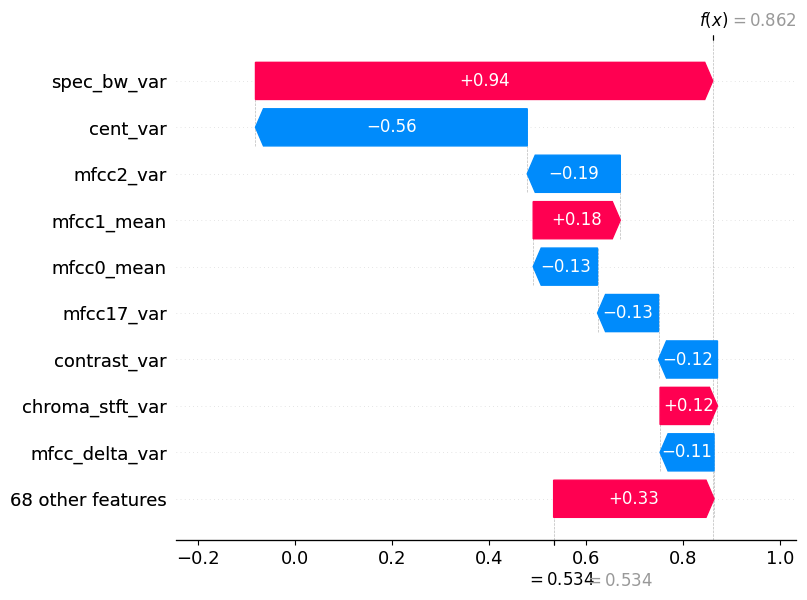

In [24]:
# Reshape the SHAP values to match the number of features
reshaped_shap_values = shap_values[0].reshape(-1)  # Flatten the SHAP values to 1D

# Visualize the waterfall plot
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], reshaped_shap_values, feature_names=list(df.columns))

From the SHAP waterfall plot

we can see that the Base Value f(x) = 0.862 
- the base value is the expected model output if none of the feature had any effect. This might be due to Class imbalance or model bias for X_train 

The Final Output f(x) = 0.534 > 0.5, therefore predicting 1
- This prediction results from adding the contribution (SHAP values) of each features to the base value

The feature contribution can be seen from each bar, each bar represent a feature and its contribution to pushing the model's prediction away from the base value (either increasing or decreasing it) 

-  Red bars indicate features that push the prediction higher (positive impact on prediction).
- Blue bars indicate features that push the prediction lower (negative impact on prediction).

We can also see the Top features
- The most impactful feature is the spec_bw_var


In [25]:
# Read the dataset
df = pd.read_csv('simplified.csv')

# Create the label from the filename since filename contains the label
df['label'] = df['filename'].str.split('_').str[-2]
df['label'].value_counts()

label
pos    6202
neg    5855
Name: count, dtype: int64